Hello My Second Notebook w.r.t House Regression Problems!  
(Update) Visualization is so interesting. Even if I draw new graphs every day in this kernel, but I couldn't find the end!  

This Visualization is centered at GrLivArea which has the largest correlation with the target SalePrice. You can see the various variables to make the power of GrLivArea be excellent.  
Without further do, Let's go!

---
00. Imputation & Outlier Remedy
01. Exploratory Data Analysis
    - OverallQuality + @ (update, 180125 Korea Time)
    - 2ndFlr & Basement
    - Bath + @ (update, 180125 Korea Time)
    - Technical Room + @ (update-Reshape, 180126 Korea Time)
    - Garage
    - Outside
    - Season
    #(Sale: SaleCondition, SaleType / Condition: Condition1, Condition2 / PavedDrice)

02. Statistical Engineering
    - Boxcox 
    - Skewness & Kurtosis 
    - Non-Parametric 
    - Min Cnt size / 1. Merge (180122)  2. CurOff(180129, Kor Time Update)

03. Visualiing
    - 3D Plot

In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import random
import warnings
import scipy
from scipy.stats import boxcox, boxcox_normmax
# import plotly.offline as py
# py.init_notebook_mode(connected=True)
# import plotly.graph_objs as go
# import plotly.tools as tls
# warnings.filterwarnings('ignore')
# import plotly.figure_factory as ff

df_train = pd.read_csv('../Desktop/Github/Kaggle/1_House_Price_Project_X/train.csv')

df_train.drop(['MiscVal'], axis = 1, inplace = True)
#1. Convert NA into 'No' Categorical values
meaningfulNA = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 
 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
df_train[meaningfulNA] = df_train[meaningfulNA].fillna('No')

intVar = df_train.select_dtypes(include = ['int']).columns.tolist()
floatVar = df_train.select_dtypes(include = ['float']).columns.tolist()
objectVar = df_train.select_dtypes(include = ['object']).columns.tolist()

## 1. Imputation & Outlier Remedy

#### 1.1. Imputation

In [9]:
print('Step1. Find Null Varialbes')
#print('Null Variables :' ,list(df_train.isnull().sum()[df_train.isnull().sum() != 0].index))

nullIndex = df_train.isnull().any().index[df_train.isnull().any()]
nullTrain = df_train.loc[:, nullIndex].copy()
for col in nullTrain.columns:
    nullPos = nullTrain[col].isnull()
    nullTrain.loc[~nullPos, col] = 'Exist'
    nullTrain.loc[nullPos, col] = 'Null'

nullTrain = nullTrain.apply(lambda x: pd.Series.value_counts(x)).T
nullTrain = nullTrain.sort_values('Exist')

trace1 = go.Bar(
    x = nullTrain['Exist'],
    y = nullTrain.index,
    name = 'Exist',
    orientation = 'h',
    marker = dict(
        color = 'rgba(246, 78, 139, 0.6)',
        line = dict(
            color = 'rgba(246, 78, 139, 1.0)',
            width = 3)
    )
)
trace2 = go.Bar(
    x = nullTrain['Null'],
    y = nullTrain.index,
    name = 'Null',
    orientation = 'h',
    marker = dict(
        color = 'rgba(58, 71, 80, 0.6)',
        line = dict(
            color = 'rgba(58, 71, 80, 1.0)',
            width = 3)
    )
)


data = [trace1, trace2]
layout1 = go.Layout(
    width = 800,
    height = 400,
    barmode = 'stack',
    title = 'Null Value BarPlot'
    )
fig = go.Figure(data = data, layout = layout1)


#print((df_train.isnull().sum()[df_train.isnull().sum() != 0]) / df_train.shape[0])
#print('')
py.iplot(fig)
indexList = df_train.index
print('Number of Missing Index Sum (MaxVnrType, MasVnrARea, Electrical) : ', sum(indexList[df_train[['MasVnrType', 'MasVnrArea', 'Electrical']].isnull().sum(axis=1)]))
df_train = df_train.loc[df_train[['Electrical', 'MasVnrArea', 'MasVnrType']].isnull().sum(axis=1) == 0, :]

print('Correlation Between GarageYrBlt and YearBlt: ', df_train[['GarageYrBlt', 'YearBuilt']].corr().loc['GarageYrBlt', 'YearBuilt'].round(2))
val = round(max(df_train.corr().loc['LotFrontage', :].drop('LotFrontage')),2)
print('Max Correlation of LotFrontage : ', val)
print('-- Linear Imputation : LotFrontage-- ')
from sklearn import linear_model
dfImpute = df_train.loc[:, ['1stFlrSF', 'LotArea', 'LotFrontage']].copy()
testIx = dfImpute.loc[:,'LotFrontage'].isnull()
dfTrain = dfImpute.loc[~testIx, :]
dfTest = dfImpute.loc[testIx, :]
lr = linear_model.LinearRegression()
lr.fit(dfTrain.loc[:, ['1stFlrSF', 'LotArea', 'LotArea']], dfTrain.loc[:, 'LotFrontage'])
lrImpute = lr.predict(dfTest.loc[:, ['1stFlrSF', 'LotArea', 'LotArea']])

Step1. Find Null Varialbes


NameError: name 'go' is not defined

- Delete rows where (MaxVnrType, MaxVnrArea, Electircal) is missing since the total number of missing was so small
- GarageYrBlt drop out of columns since the correlation with YearBlt was so strong
- LotFrontage Imputed by Linear Regression

---

#### 1.2. Outlier
By Univariate Oultiers and Bivariate Outliers  & Helper Function

In [10]:
from collections import Counter, defaultdict
def checkOutlier(df, m = 4):
    uniOutlier = dict().fromkeys(df.columns, None)
    outSample = abs(df - df.mean()) > 4 * df.std()
    outSum = (abs(df - df.mean()) > 4 * df.std()).sum()
    for key in uniOutlier.keys():
        uniOutlier[key] = set(outSample.index[outSample.loc[:, key]])
    outportion = outSum / df.shape[0]
    #print("No outlier Vars: " ,outSum.index[outportion == 0].tolist())
    #print("Outlier Portion")
    #print(outportion[outportion != 0].index.tolist())
    #print(outportion[outportion != 0].values.tolist())
    outportion = outportion[outportion != 0].sort_values()
    outlierLst = outportion.index.tolist()
    return uniOutlier, outlierLst

from collections import Counter
def outlierCounter(outlierDict, exceptionLst = ['SalePrice']):
    inter = Counter()
    name = defaultdict(list)
    coreKey = set(outlierDict.keys()).difference(exceptionLst)
    for key in coreKey:
        value = outlierDict[key]
        for val in value:
            inter[val] += 1
            name[val].append(key)
    res = pd.DataFrame([inter, name], index = ['count', 'variable']).T
    res = res.sort_values('count', ascending = False)
    return res

from scipy.stats import multivariate_normal
def bivarCI(dfNum, y = 'SalePrice', outer = 10, z_score = 0.00006, cols = 2):
    
    colNum = dfNum.shape[1]
    row, col = divmod(colNum-1, cols)
    if row == 1 and col == 0: row += 1
    if col != 0: row += 1
    
    
    z_under = z_score * 0.98
    z_upper = z_score * 1.02
    
    biOutlier = dict().fromkeys(dfNum.columns, None)
    #f, axes = plt.subplots(row, cols, figsize = (4*cols, 4*row))
    #f.suptitle('Bivaraite CI', fontsize = 12)
    for ix, var1 in enumerate(dfNum.columns):
        if var1 == y: break
        r,c = divmod(ix, cols)
        dfPart = dfNum.loc[:, [var1,y]]
        dfPart = dfPart[~dfPart.isnull()].copy()
        dfPart = dfPart.loc[dfPart.loc[:, var1] != 0,:]
        dfPart = (dfPart - dfPart.mean()) / dfPart.std()
        F, X, Y, posProb = bivarConverter(dfPart, outer, z_under, z_upper, N = 700)
        #axes[r,c].contourf(X, Y, posProb)
        #axes[r,c].scatter(dfPart.loc[:, var1], dfPart.loc[:, y], alpha = 1)
        #axes[r,c].set_title('Bivaraite CI ' + var1)
        dfPartProb = F.pdf(dfPart.values)
        outIndex = dfPart.index[dfPartProb < z_score]
        biOutlier[var1] = set(outIndex.tolist())
    #f.tight_layout(rect = [0, 0.03, 1, 0.95])
    #plt.show()
    
    return biOutlier

def bivarConverter(df, outer, z_under, z_upper, N = 500):
    x_init, y_init = df.min() - outer
    x_end, y_end = df.max() + outer
    X = np.linspace(x_init, x_end, N)
    Y = np.linspace(y_init, y_end, N)
    X, Y = np.meshgrid(X, Y)
    pos = np.empty(X.shape + (2,))
    pos[:,:,0] = X
    pos[:,:,1] = Y
    F = multivariate_normal(mean=df.mean().values, cov=df.corr().values)
    posProb = F.pdf(pos)
    posProb[(z_under < posProb) & (posProb < z_upper)] = 1
    posProb[(z_under > posProb) | (posProb < z_upper)] = 0
       
    return F , X, Y, posProb

In [11]:
cols = ['GrLivArea', 'LotArea', '1stFlrSF', 'TotalBsmtSF', 'SalePrice']
uniOutlier, outlierList = checkOutlier(df_train.loc[:, cols])
uniOut = outlierCounter(uniOutlier, ['SalePrice'])
biOutlier = bivarCI(df_train.loc[:, cols], outer = 2, z_score = 0.00006,  cols = 4)
biOut = outlierCounter(biOutlier, ['SalePrice', ])
totOut = uniOut.join(biOut, lsuffix='_uni', rsuffix='_bi')
print('Top 3 Outlier')
totOut.head(3)

Top 3 Outlier


,count_uni,variable_uni,count_bi,variable_bi
1298,4,"[TotalBsmtSF, 1stFlrSF, GrLivArea, LotArea]",4,"[TotalBsmtSF, 1stFlrSF, GrLivArea, LotArea]"
523,3,"[TotalBsmtSF, 1stFlrSF, GrLivArea]",3,"[TotalBsmtSF, 1stFlrSF, GrLivArea]"
496,2,"[TotalBsmtSF, 1stFlrSF]",2,"[TotalBsmtSF, 1stFlrSF]"


In [12]:
outIndex = [1298, 769, 706, 249, 313, 457, 451, 384, 335, 1396]
outIndex2 = [1298, 523, 496, 440, 332]
outpos =  df_train.index.isin(outIndex)
inpos = ~outpos
outpos2 = df_train.index.isin(outIndex2)
inpos2 = ~outpos2

trace1 = go.Scatter(
    x = df_train.loc[inpos,'LotArea'],
    y = df_train.loc[inpos,'SalePrice'],
    mode = 'markers',
    marker = dict(
        color='rgba(217, 217, 217, 1.0)',
    ),
    text = 'Inner'
)
trace2 =  go.Scatter(
    x = df_train.loc[outIndex,'LotArea'],
    y = df_train.loc[outIndex, 'SalePrice'],
    mode = 'markers',
    marker = dict(
        color= 'rgba(156, 165, 196, 0.95)',
    ),
    text = 'Outlier'
)

trace3 = go.Scatter(
    x = df_train.loc[inpos2, 'LotArea'],
    y = df_train.loc[inpos2,'TotalBsmtSF'],
    mode = 'markers',
    marker = dict(
        color='rgba(217, 217, 217, 1.0)',
    ),
    xaxis = 'x2',
    yaxis = 'y2',
    text = 'Inner'
)
trace4 =  go.Scatter(
    x = df_train.loc[outIndex,'LotArea'],
    y = df_train.loc[outIndex, 'TotalBsmtSF'],
    mode = 'markers',
    marker = dict(
        color= 'rgba(156, 165, 196, 0.95)',
    ),
    xaxis = 'x2',
    yaxis = 'y2',
    text = 'Outlier'
)

xaxisDict =  dict(
            ticklen = 5,
            showgrid = True,
            zeroline = False,
            showline = False)
yaxisDict = dict(
        showgrid = True,
        zeroline = False,
        ticklen =5,
        gridwidth = 0
    )
data = [trace1, trace2, trace3, trace4]
layout = go.Layout(
    width = 800,
    height = 400,
    title = 'Outlier Detection',
    hovermode = 'closest',
    paper_bgcolor='rgb(254, 247, 234)',
    plot_bgcolor='rgb(254, 247, 234)',
    xaxis1 = xaxisDict,
    yaxis1 = yaxisDict,
    xaxis2 = xaxisDict,
    yaxis2 = yaxisDict,
    showlegend = False
)

fig = go.Figure(data = data, layout = layout)
fig.layout.xaxis1.update({'anchor': 'y1', 'domain' : [0, 0.45], 'title': 'LotArea'})
fig.layout.yaxis1.update({'anchor': 'x1', 'domain': [0, 1], 'title': 'SalePrice'})
fig.layout.xaxis2.update({'anchor': 'y2', 'domain' : [0.65, 1], 'title':'LotArea'})
fig.layout.yaxis2.update({'anchor': 'x2', 'domain': [0, 1], 'title' : 'TotalBsmtSF'})
fig.layout.margin.update({'t':75, 'l':50})

py.iplot(fig)
###
df_train = df_train.loc[~df_train.index.isin(totOut.index),:]

NameError: name 'go' is not defined

- Absoultely get rid of the calculated Outliers

---

## 2. Group & SalePrice

### 2.0 GrLivArea

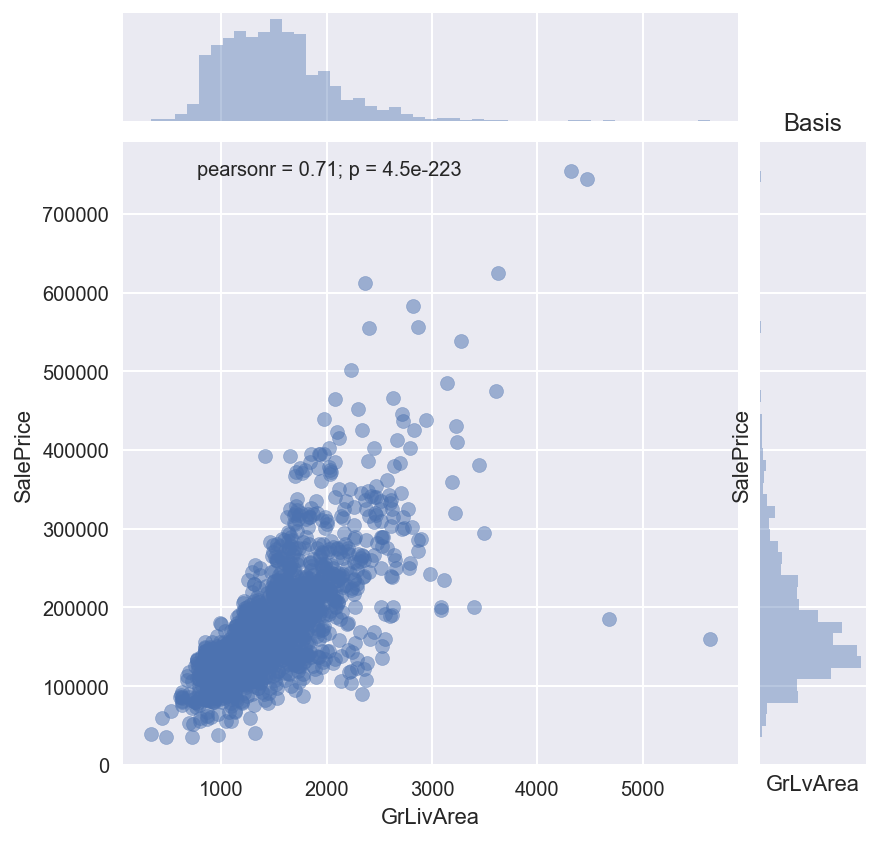

In [13]:
plt.figure(figsize = (6, 3))
sns.jointplot(df_train.GrLivArea, df_train.SalePrice, alpha = 0.5)
plt.xlabel('GrLvArea')
plt.ylabel('SalePrice')
plt.title('Basis')
plt.show()

Even though GrLivArea is the most powerful variable of SalePrice, it's not enough! You can see the larger GrLivArea, the linearity was even far collapsed (In statistic, it is called 'Corn Shape Heteroscedasticity')  Our mission is to let know what variables makes us to figure out inner strucutre

### 2.1. OverallQual

Mean squared error: 2027943231.15


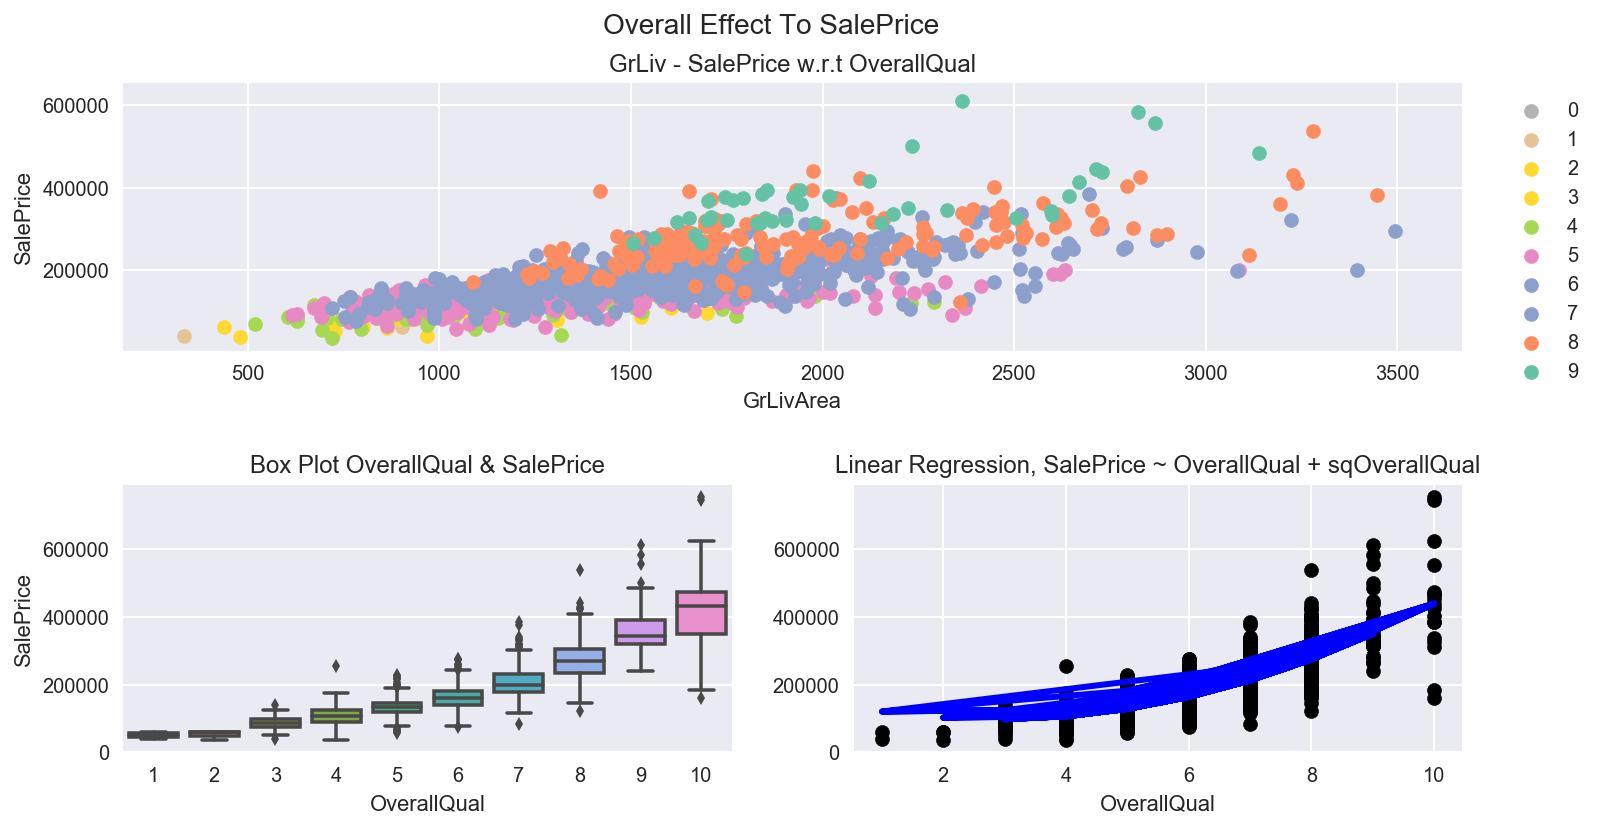

In [14]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

plt.figure(figsize = (12,6))
ax1 = plt.subplot2grid((2,2), (0,0), colspan = 2)
ax1.set_color_cycle(sns.color_palette('Set2_r', 10))
for val in range(10):
    indeX = df_train.OverallQual == val
    ax1.scatter(df_train.GrLivArea.loc[indeX], df_train.SalePrice.loc[indeX], label = val)
ax1.legend(bbox_to_anchor = [1.1, 1])
ax1.set_xlabel('GrLivArea')
ax1.set_ylabel('SalePrice')
ax1.set_title('GrLiv - SalePrice w.r.t OverallQual')

ax2 = plt.subplot2grid((2,2), (1,0))
sns.boxplot(x = 'OverallQual', y = 'SalePrice', data = df_train, ax = ax2)
ax2.set_title('Box Plot OverallQual & SalePrice', fontsize = 12)

ax3 = plt.subplot2grid((2,2), (1,1))
cubicQual = df_train.groupby(['OverallQual'])['SalePrice'].mean().round(0)
testTrain = df_train.loc[:, ['OverallQual', 'SalePrice']].copy()
testTrain['sqOverallQual'] = np.power(testTrain['OverallQual'],2)
mdl = linear_model.LinearRegression()
mdl.fit(testTrain[['OverallQual', 'sqOverallQual']], testTrain['SalePrice'])
y_pred = mdl.predict(testTrain[['OverallQual', 'sqOverallQual']])
print("Mean squared error: %.2f" % mean_squared_error(y_pred, testTrain.SalePrice))
# Plot outputs
ax3.scatter(testTrain['OverallQual'], testTrain['SalePrice'],  color='black')
ax3.plot(testTrain['OverallQual'], y_pred, color='blue', linewidth=3)
ax3.set_title('Linear Regression, SalePrice ~ OverallQual + sqOverallQual', fontsize = 12)
ax3.set_xlabel('OverallQual')
plt.subplots_adjust(hspace = 0.5, top = 0.9)
plt.suptitle('Overall Effect To SalePrice', fontsize = 14)
plt.show()


OverallQual is the best variables among Ordinal Variables regard of explaining SalePrice. I Love to see OverallQual  
Find
- **OverallQual causes different SalePrice where having same "GrLivArea". We have to put a strong attention!**
- OverallQual was proportional to SalePrice, and (1-2) almost identical.
- Square of OverallQual was a good variables since linear regression (SalePrice ~ O.Q + O.Q^2) has good curve shape

### 2.2. 2ndFlr & Basement

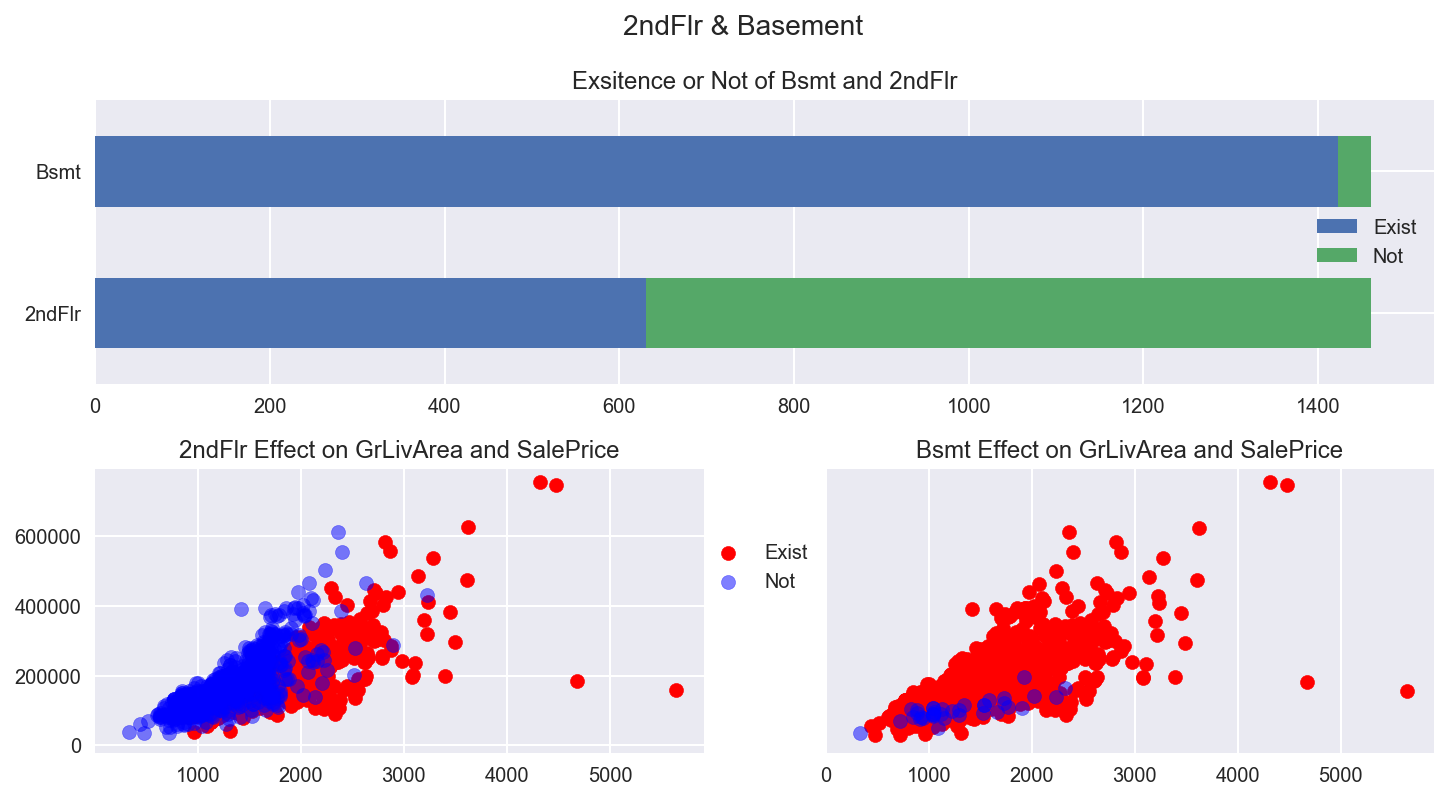

In [15]:
plt.figure(figsize = (12,6))
tf_train = df_train[['OverallQual','2ndFlrSF', 'TotalBsmtSF', 'SalePrice']].copy()
tf_train['GrLivArea'] = df_train['GrLivArea'].copy()
tf_train['2ndFlr'] = 'Exist'
tf_train.loc[tf_train['2ndFlrSF'] == 0 ,'2ndFlr'] = 'Not'
tf_train['Bsmt'] = 'Exist'
tf_train.loc[tf_train['TotalBsmtSF'] == 0 ,'Bsmt'] = 'Not'
ax1 = plt.subplot2grid((2,2), (0,0), colspan = 2)
tmp = tf_train[['2ndFlr', 'Bsmt']].apply(pd.Series.value_counts).T
tmp.plot.barh(stacked = True, ax = ax1)
ax1.set_title('Exsitence or Not of Bsmt and 2ndFlr', fontsize = 12)
ax2 = plt.subplot2grid((2,2), (1,0))
ax2.scatter(tf_train['GrLivArea'].loc[tf_train['2ndFlr'] == 'Exist'], tf_train['SalePrice'].loc[tf_train['2ndFlr'] == 'Exist'], color = 'r', alpha = 1, label = 'Exist')
ax2.scatter(tf_train['GrLivArea'].loc[tf_train['2ndFlr'] != 'Exist'], tf_train['SalePrice'].loc[tf_train['2ndFlr'] != 'Exist'], color = 'b', alpha = 0.5, label = 'Not')
ax2.set_title('2ndFlr Effect on GrLivArea and SalePrice')
ax2.legend(bbox_to_anchor = [1.2, 0.8])

ax3 = plt.subplot2grid((2,2), (1,1))
ax3.scatter(tf_train['GrLivArea'].loc[tf_train['Bsmt'] == 'Exist'], tf_train['SalePrice'].loc[tf_train['Bsmt'] == 'Exist'], color = 'r', alpha = 1)
ax3.scatter(tf_train['GrLivArea'].loc[tf_train['Bsmt'] != 'Exist'], tf_train['SalePrice'].loc[tf_train['Bsmt'] != 'Exist'], color = 'b', alpha = 0.5)
ax3.set_yticks([])
ax3.set_title('Bsmt Effect on GrLivArea and SalePrice')
plt.subplots_adjust(hspace = 0.3, wspace = 0.2)
plt.suptitle('2ndFlr & Basement', fontsize = 14)
plt.show()

Find
- 2ndFlrSF depressed the power of GrLiva toward SalePrice
- Bsmt has nothing related to the price, so I won't see anymore related to Bsmt

### 2.3. Bath

In [16]:
bath = ['FullBath','HalfBath']#'BsmtFullBath', 'BsmtHalfBath',
cm = sns.light_palette("green", as_cmap=True)
pd.crosstab(df_train[bath[0]], df_train[bath[1]]).style.background_gradient(cmap = cm)

HalfBath,0,1,2
FullBath,,,
0,3,3,3
1,466,180,4
2,429,334,5
3,15,18,0


Full Correlation (GrLivArea - SalePrice)  0.71
(1, 0)Correlation 0.45 
(1, 1)Correlation 0.56 
(2, 0)Correlation 0.35 
(2, 1)Correlation 0.63 


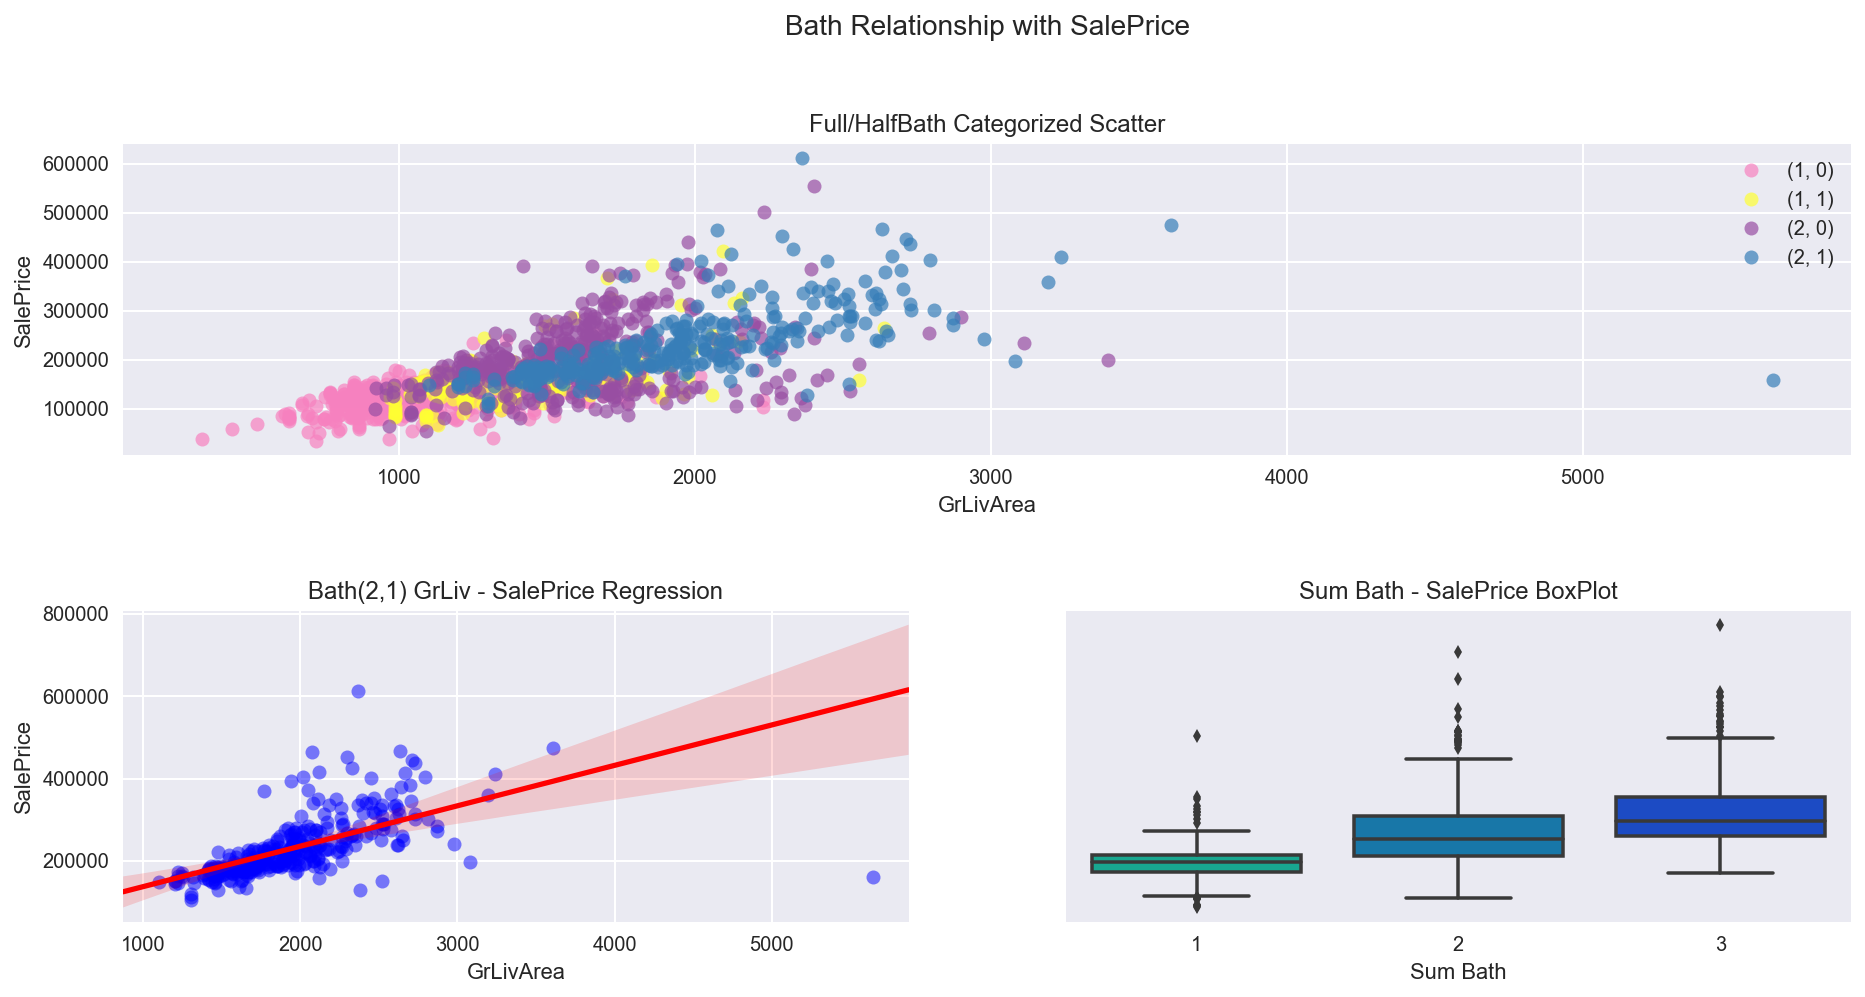

In [17]:
plt.figure(figsize = (12,6))
ax1= plt.subplot2grid((2,2), (0,0), colspan = 2)
#colors = pandas.tools.plotting._get_standard_colors(10, color_type = 'random')
colors = sns.color_palette('Set1_r', 4)
ax1.set_color_cycle(colors)
groups = df_train.groupby(['FullBath', 'HalfBath'])
print('Full Correlation (GrLivArea - SalePrice) % .2f' % np.corrcoef(df_train['GrLivArea'], df_train['SalePrice'])[0][1])
for name, group in groups:
    if name in ((1,0), (1,1), (2,0), (2,1)):
        print(str(name) + 'Correlation %.2f ' % np.corrcoef(group['GrLivArea'], group['SalePrice'])[0][1])
        ax1.plot(group['GrLivArea'], group['SalePrice'], marker = 'o', linestyle = '', label = name, alpha = 0.7)
ax1.legend(loc = 'upper right')
ax1.set_title('Full/HalfBath Categorized Scatter')
ax1.set_xlabel('GrLivArea')
ax1.set_ylabel('SalePrice')

ax2= plt.subplot2grid((2,2), (1,0))
sns.regplot(x = 'GrLivArea', y = 'SalePrice', order = 1,
            data = df_train.loc[(df_train['FullBath'] == 2 ) & (df_train['HalfBath']==1), ['GrLivArea', 'SalePrice']], 
            ax = ax2, line_kws = {'color' : 'red'}, scatter_kws = {'color' : 'blue', 'alpha' : 0.5})
ax2.set_title('Bath(2,1) GrLiv - SalePrice Regression')

ax3= plt.subplot2grid((2,2), (1,1))
testTrain = df_train.loc[:, ['GrLivArea', 'SalePrice']].copy()
testTrain['Bath'] = df_train[['FullBath', 'HalfBath']].sum(axis = 1)
sns.boxplot(x = 'Bath', y = 'SalePrice', order= [1,2,3], data =testTrain, ax =ax3, palette =sns.color_palette('winter_r',3))
ax3.set_title('Sum Bath - SalePrice BoxPlot')
ax3.set_yticks([])
ax3.set_ylabel('')
ax3.set_xlabel('Sum Bath')

plt.subplots_adjust(0,0,1, 0.9,hspace = 0.5)
plt.suptitle('Bath Relationship with SalePrice', fontsize = 14, y = 1.05)
sns.despine(left = True)
plt.show()

Find:
- The  Number of Bath usually increased the SalePrice, but especially (Full 2, Half1) improved the linearity and decreased the spreadness of SalePrice - GrLivArea.

### 2.4. Techical Room

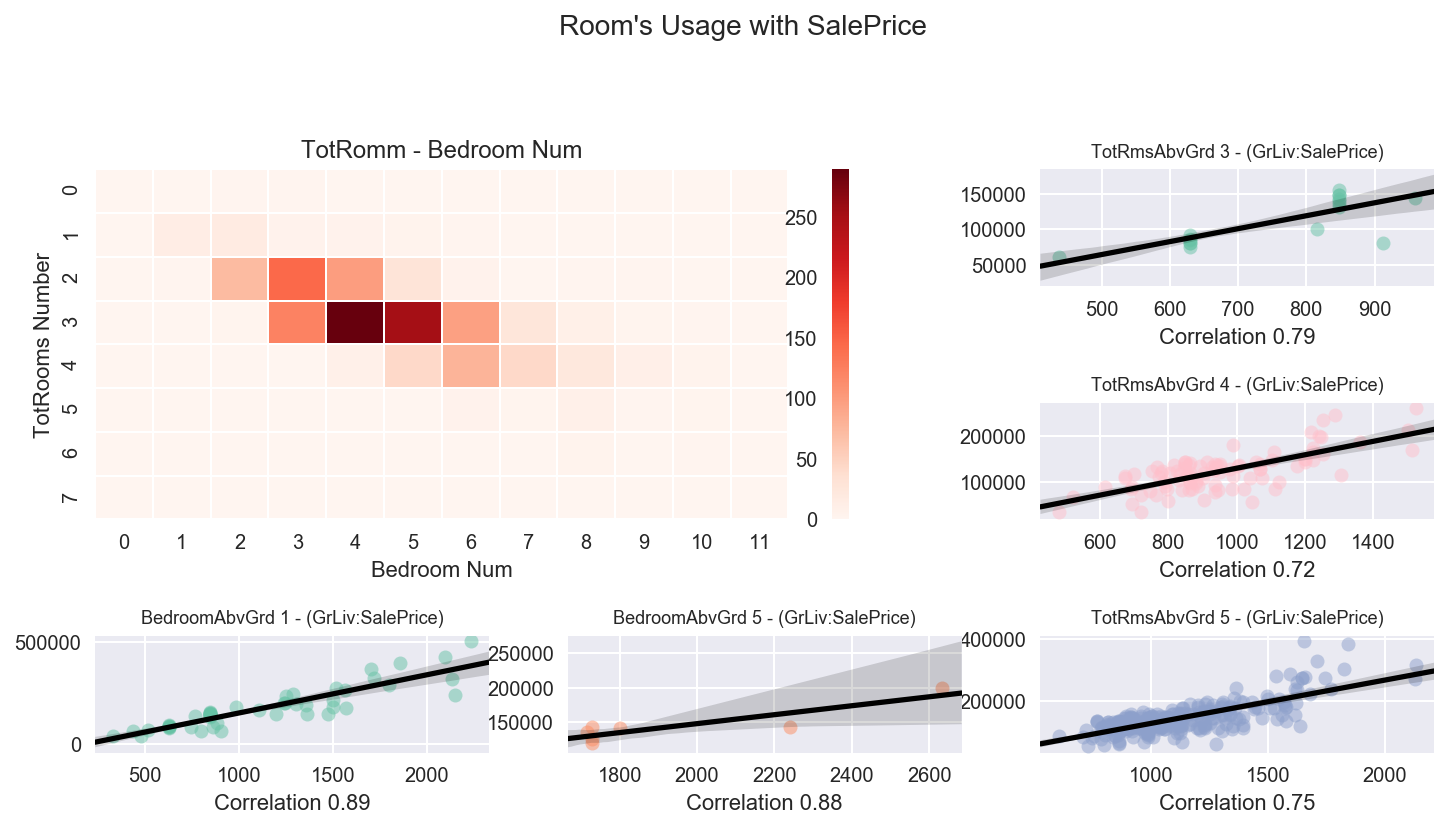

In [18]:
plt.figure(figsize = (12,6))
ax = plt.subplot2grid((3,3), (0,0), rowspan = 2, colspan = 2)
bath = ['BedroomAbvGr', 'TotRmsAbvGrd']#'BsmtFullBath', 'BsmtHalfBath',
test = pd.crosstab(df_train[bath[0]], df_train[bath[1]])
sns.heatmap(test.values, cmap = plt.cm.Reds, ax = ax, linewidths=.5), #yticklabels=False, xticklabels=False)
ax.set_ylabel('TotRooms Number')
ax.set_xlabel('Bedroom Num')
ax.set_title('TotRomm - Bedroom Num')


ax2 = plt.subplot2grid((3,3), (0,2))
colors = sns.color_palette('Set2',3)
pack = [3,4,5]
val = pack[0]
sns.regplot(x='GrLivArea', y = 'SalePrice', data = df_train.loc[df_train.TotRmsAbvGrd == val], 
            scatter_kws = {'color' : colors[val-3], 'alpha' : 0.5}, line_kws = {'color' : 'k'}, ax = ax2)
#ax2.set_yticklabels([])
ax2.set_title('TotRmsAbvGrd 3 - (GrLiv:SalePrice)', fontsize = 9)
ax2.set_ylabel('')
ax2.set_xlabel('Correlation ' + str(df_train.loc[df_train.TotRmsAbvGrd == val, ['GrLivArea', 'SalePrice']].corr().round(2).loc['GrLivArea','SalePrice']))

ax3 = plt.subplot2grid((3,3), (1,2))
val = pack[1]
sns.regplot(x='GrLivArea', y = 'SalePrice', data = df_train.loc[df_train.TotRmsAbvGrd == val], 
            scatter_kws = {'color' : 'pink', 'alpha' : 0.5}, line_kws = {'color' : 'k'}, ax = ax3)
#ax3.set_yticklabels([])
ax3.set_ylabel('')
ax3.set_title('TotRmsAbvGrd 4 - (GrLiv:SalePrice)' , fontsize = 9)
ax3.set_xlabel('Correlation ' + str(df_train.loc[df_train.TotRmsAbvGrd == val, ['GrLivArea', 'SalePrice']].corr().round(2).loc['GrLivArea','SalePrice']))
ax3.legend()

ax4 = plt.subplot2grid((3,3), (2,2))
val = pack[2]
sns.regplot(x='GrLivArea', y = 'SalePrice', data = df_train.loc[df_train.TotRmsAbvGrd == val], 
            scatter_kws = {'color' : colors[val-3], 'alpha' : 0.5}, line_kws = {'color' : 'k'}, ax = ax4)
#ax4.set_yticklabels([])
ax4.set_title('TotRmsAbvGrd 5 - (GrLiv:SalePrice)' , fontsize = 9)
ax4.set_ylabel('')
ax4.set_xlabel('Correlation ' + str(df_train.loc[df_train.TotRmsAbvGrd == val, ['GrLivArea', 'SalePrice']].corr().round(2).loc['GrLivArea','SalePrice']))

pack = [1,6]

ax5 = plt.subplot2grid((3,3), (2,0))
val = pack[0]
sns.regplot(x='GrLivArea', y = 'SalePrice', data = df_train.loc[df_train.BedroomAbvGr == val], 
            scatter_kws = {'color' : colors[0], 'alpha' : 0.5}, line_kws = {'color' : 'k'}, ax = ax5)
#ax4.set_yticklabels([])
ax5.set_title('BedroomAbvGrd 1 - (GrLiv:SalePrice)' , fontsize = 9)
ax5.set_ylabel('')
ax5.set_xlabel('Correlation ' + str(df_train.loc[df_train.BedroomAbvGr == val, ['GrLivArea', 'SalePrice']].corr().round(2).loc['GrLivArea','SalePrice']))

ax6 = plt.subplot2grid((3,3), (2,1))
val = pack[1]
sns.regplot(x='GrLivArea', y = 'SalePrice', data = df_train.loc[df_train.BedroomAbvGr == val], 
            scatter_kws = {'color' : colors[1], 'alpha' : 0.5}, line_kws = {'color' : 'k'}, ax = ax6)
#ax4.set_yticklabels([])
ax6.set_title('BedroomAbvGrd 5 - (GrLiv:SalePrice)' , fontsize = 9)
ax6.set_ylabel('')
ax6.set_xlabel('Correlation ' + str(df_train.loc[df_train.BedroomAbvGr == val, ['GrLivArea', 'SalePrice']].corr().round(2).loc['GrLivArea','SalePrice']))


sns.despine(left = True)


plt.subplots_adjust(top = 0.8, hspace = 1)
plt.suptitle("Room's Usage with SalePrice", fontsize = 14)
plt.show()

Find
- HeatMap Said "TotRomAbvGrd ~ BedroomAbvGrd ~ Bath" are proportional to each other! 
- At TotRmsAbvGrd (3,4,5), the linearity w.r.t GrLiv-SalePrice was over 0.71.
- At BedroomAbvGrd (0,1,2,3,4,5,6), the correlation wr.t. GrLiv-SalePrice was over 0.73

### 2.5. Garage

In [ ]:
garage = ['GarageCars', 'GarageArea']
plt.figure(figsize = (12,6))
ax2 = plt.subplot2grid((2,3), (1,0))
palette = sns.color_palette('Set1',5)
sns.countplot(df_train['GarageCars'], ax = ax2, palette = palette)
ax2.set_title('Number of Occurences of GarageCars')

ax3 = plt.subplot2grid((2,3), (0,0), colspan = 3)
ax3.set_color_cycle(palette)
for val in range(5):
    indexV = df_train.GarageCars == val
    ax3.plot(df_train['GarageArea'].loc[indexV], df_train['SalePrice'].loc[indexV], marker = 'o', linestyle = '', label = val, alpha = 0.7)
ax3.set_xlabel('GarageArea')
ax3.set_ylabel('SalePrice')
ax3.set_title('Scatter x: GarageArea, y : SalePrice')
ax3.set_yticklabels([])
ax3.legend()

ax = plt.subplot2grid((2,3), (1,2))
num = [0,1,2,3]
ax.set_color_cycle(sns.color_palette('Set2', 4))
for val in num:
    index = df_train.GarageCars == val
    ax.scatter(df_train.GrLivArea.loc[index], df_train.GarageArea.loc[index], label = val, alpha = 0.5)
ax.set_xlabel('GrLivArea')
ax.set_ylabel('GarageArea')
ax.set_title('Scatter x: GrLivArea, y : GarageArea')
ax.legend()

def functions(x):
    if x['GarageCars'] == 0: return 0
    else:
        return x['GarageArea']/ x['GarageCars']
unitCarArea = df_train.apply(functions, axis = 1)

ax3= plt.subplot2grid((2,3), (1,1))
ax3.set_color_cycle(palette)
for val in range(4):
    indexV = df_train.GarageCars == val
    ax3.plot(unitCarArea.loc[indexV], df_train['SalePrice'].loc[indexV], marker = 'o', linestyle = '', label = val, alpha = 0.7)
ax3.set_xlabel('Unit_GarageArea')
ax3.set_ylabel('SalePrice')
ax3.set_title('Unit CarArea Effect')
ax3.set_yticklabels([])
ax3.legend()

sns.despine(left = True)
plt.subplots_adjust(wspace = 0.3, hspace = 0.5, top =0.8)
plt.suptitle('Garage-SalePrice', fontsize = 14)
plt.show()
#df_train.GarageCars.loc[df_train.GarageCars == 4] = 3

Find
- Most of houses have two cars
- GarageArea makes Chunk having small lineratiy with SalePrice 
- 0 Cars and 1 Cars has no difference in SalePrice
- 4 Cars are simliar with 3 Cars house. Merge them
- (Update) Unt_Garage Area said that "Expensive house sustain the proper line of the area!"
- (Update) GrLivArea is a good variable not related to GarageArea. Those two variables enforces the prediction power.

### 2.6. Outside

In [ ]:
outSide = ['OpenPorchSF', 'Fireplaces','WoodDeckSF', 'EnclosedPorch','3SsnPorch', 'ScreenPorch','PoolArea']
dfOut = df_train[outSide].copy()
for x in outSide:
    dfOut[x].loc[dfOut[x] != 0] = 1
dfOut = dfOut.apply(pd.Series.value_counts).T
dfOut = dfOut / df_train.shape[0]
trace1 = go.Bar(
    x = dfOut[0],
    y = dfOut.index,
    name = 'Exist',
    orientation = 'h',
    marker = dict(
        color = 'rgba(246, 78, 139, 0.6)',
        line = dict(
            color = 'rgba(246, 78, 139, 1.0)',
            width = 3)
    )
)
trace2 = go.Bar(
    x = dfOut[1],
    y = dfOut.index,
    name = 'Null',
    orientation = 'h',
    marker = dict(
        color = 'rgba(58, 71, 80, 0.6)',
        line = dict(
            color = 'rgba(58, 71, 80, 1.0)',
            width = 3)
    )
)


data = [trace1, trace2]
layout1 = go.Layout(
    width = 800,
    height = 300,
    barmode = 'stack',
    title = 'Outside Exist or Not'
    )
fig = go.Figure(data = data, layout = layout1)

px =  plt.figure(figsize = (12,3))
#px.patch.set_facecolor('black')
ax1 = plt.subplot2grid((1,3), (0,0))
ax2 = plt.subplot2grid((1,3), (0,1))
ax3 = plt.subplot2grid((1,3), (0,2))
#According to OverQuall, WoodDeckSF's Proportion Exist or Not

for x, axis in zip(['WoodDeckSF', 'Fireplaces', 'OpenPorchSF'], [ax1, ax2, ax3]):
    dfOut = df_train[[x, 'OverallQual']].copy()
    dfOut[x].loc[dfOut[x] != 0] = 'Exist'
    dfOut[x].loc[dfOut[x] == 0] = 'None'
    tmp = pd.crosstab(dfOut[x], dfOut['OverallQual']).T
    tmp = tmp.divide(tmp.sum(axis = 1), axis = 0)
    tmp.plot.barh(stacked = True, ax = axis, legend = False)
    axis.set_title(x)
ax3.legend(bbox_to_anchor = [1.05, 1])
ax2.set_ylabel('')
ax3.set_ylabel('')
ax2.set_yticklabels('')
ax3.set_yticklabels('')
plt.subplots_adjust(top = 0.8)
plt.suptitle('Ratio of Exist(Blue)', fontsize = 13)
sns.despine()
py.iplot(fig)
plt.show()
#print((df_train.isnull().sum()[df_train.isnull().sum() != 0]) / df_train.shape[0])
#print('')

Find:
- Good Quality House has more outside instrumental places.
- PoolArea, ScreenPorch, 3SsnPorch was almost not appeared

In [ ]:
f, ax = plt.subplots(2,2, figsize = (12,6))
#FireplaceQu ={'TA': '2', 'Fa': '1', 'No': '1', 'Gd': '0', 'Po': '1', 'Ex': '0'}  
hasFire = df_train.FireplaceQu != 'No'
tmp = df_train.loc[hasFire, ['OverallQual', 'FireplaceQu', 'GrLivArea', 'SalePrice']]
res = pd.crosstab(tmp['OverallQual'], tmp['FireplaceQu'])
cols = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
sns.heatmap(res[cols], ax = ax[0,0], cmap="Blues")
ax[0,0].set_title('Fireplae - OverallQual')

colors = sns.color_palette('hls')
ax[0,1].set_color_cycle(colors)
for val in cols:
    index2 = tmp['FireplaceQu'] == val
    ax[0,1].scatter(tmp.loc[index2, 'GrLivArea'], tmp.loc[index2,'SalePrice'], label = val)
ax[0,1].legend()
ax[0,1].set_title('Fireplace Quality - GrLivArea : SalePrice')

ax[1,0].set_color_cycle(colors)
for val in range(10):
    index2 = tmp['OverallQual'] == val
    ax[1,0].scatter(tmp.loc[index2, 'GrLivArea'], tmp.loc[index2,'SalePrice'], label = val)
ax[1,0].legend()
ax[1,0].set_title('Overall Quality - GrLivArea : SalePrice')

ax[1,1].set_color_cycle(colors)
for val in ['Fa', 'TA']:
    index2 = tmp['FireplaceQu'] == val
    data = tmp.loc[index2, ['GrLivArea', 'SalePrice']]
    label = str(val) + ': '+ str(data.corr().loc['GrLivArea', 'SalePrice'].round(2))
    sns.regplot('GrLivArea', 'SalePrice', data = data, ax = ax[1,1],
               line_kws = {'color' : 'k'}, label = label)
ax[1,1].legend()
ax[1,1].set_title('Linear Fireplace Fa & TA')
ax[1,1].set_ylabel('')
ax[1,1].set_xlabel('')

plt.subplots_adjust(top = 0.9, hspace = 0.5)
plt.suptitle('Deep Dive into Fireplace Quality', fontsize = 14)
plt.show()

Find:
- Even if FireplaceQu is linear w.r.t OverallQuality, but only Fa & TA has a strong linear relationship. 
- The others collapsed linearity and caused spreadness, heteroscadasticity. Specialy See the Ex blue dots. We couldn't describe any relationship in those area.
- To easy understanding and compare the power of variable, I drew OverallQual graph again. The color dot is startified dot cluster and constrained the spreadness by value of OverallQual.

### 2.7. Season

In [ ]:
season = ['YearBuilt', 'YearRemodAdd','GarageYrBlt', 'MoSold', 'YrSold', 'SalePrice']
plt.figure(figsize = (12,6))
ax1 = plt.subplot2grid((2,2), (0,0))
sns.countplot(x = 'MoSold', palette = sns.color_palette('winter', 12), data =df_train, ax = ax1)
ax1.set_title('Trade Count Per Month')

ax2 = plt.subplot2grid((2,2), (0,1))
ax2.scatter(x = df_train['YearBuilt'], y = df_train['YearRemodAdd'], alpha = 0.5, color = 'g')
ax2.axvline(1950, color = 'red', linewidth = 2.5)
ax2.axhline(1950, color = 'red', linewidth = 2.5)
ax2.set_xlabel('Built Year')
ax2.set_ylabel('Remod Year')
ax2.set_title('Built - Remod Year')

ax3 = plt.subplot2grid((2,2), (1,0), colspan = 2)
sns.regplot(x = 'YearBuilt', y = 'SalePrice', color = 'pink', order = 2, line_kws = {'color' : 'red'}, ax = ax3, data =df_train)
ax3.set_title('YearBuilt - SalePrice')
plt.subplots_adjust(top = 0.9, hspace = 0.4)
plt.suptitle('Season & SalePrice', fontsize = 14)
#sns.despine()
plt.show()

Find
- The amount of trade was increased by rising temperature
- Most of old built house remodeled at 1950. 
- The part of house, built after 1950, was not remodeled yet
- YearBuilt^2 is proper if the variables is used to predict

---

## 3. TransFormation

### 3.1. BoxCox Engineering
 Boxcox calcualate the proper lambda, which inverse or power. For example, if one variables have round(lambda) = 0, Log transform needed. And in round(lambda) = 2 case, the variable changed as variable^2. (It is useful in the range(-5,5). But some material said (-2,2) transformation is enough)

In [ ]:
numNone = ['GrLivArea', 'LotArea', '1stFlrSF', 'TotalBsmtSF', 'GarageArea']
numZero = ['2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF']
#season = ['YearBuilt', 'YearRemodAdd', 'MoSold', 'YrSold']
#numInt = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd']
#etc = ['GarageCars', 'OpenPorchSF', 'Fireplaces', 'WoodDeckSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea']

def tf(data):
    if min(data) <= 0:
        return data + abs(min(data)) + 1
    return data
def transformed(val):
    if val == 0: return 'log'
    elif val == 1: return 'stay'
    elif val == -1: return 'inverse'
    elif val <= -2: return 'square inverse'
    elif val >= 2: return 'square'

cols = numNone + numZero + ['SalePrice']
numZero_tf = dict()
for col in cols:
    numZero_tf[col] = round(scipy.stats.boxcox_normmax(df_train[col].loc[df_train[col] != 0]),2)
test = pd.DataFrame.from_dict(numZero_tf, orient = 'index').T
test.rename(index = {0: 'boxCox'}, inplace = True)
f, ax = plt.subplots(1,1,figsize = (8,4))
sns.barplot(x = test.iloc[0,:], y = test.columns, orient = 'h')
ax.axvline(x=0.5, color = 'red')
ax.set_xticklabels(test.iloc[0,:])
ax.set_title('Lambda BoxCox Plot', fontsize = 14)
plt.show()

Find
1. Except 2ndFlrSF, BsmtFinSF1, the other variables need to deal with by Log Transformation
2. Go to compare it!

In [ ]:
logTF = ['1stFlrSF', '2ndFlrSF']
df_train['logSalePrice'] = logPrice =  np.log1p(df_train['SalePrice'])
colors = sns.color_palette('Set1',8)
f, ax = plt.subplots(1, 4, figsize = (12, 3))
ax[0].set_title('1stFlrSF')
ax[0].scatter(df_train['1stFlrSF'], logPrice, c = colors[0], alpha = 0.5)
ax[1].set_title('Recommend Log1stFlrSF')
ax[1].scatter(np.log1p(df_train['1stFlrSF']),logPrice,  c = colors[1], alpha = 0.5)
ax[2].set_title('Recommend 2ndFlrSF')
indexL = df_train['2ndFlrSF']!= 0
ax[2].scatter(df_train['2ndFlrSF'].loc[indexL], df_train['logSalePrice'].loc[indexL], c = colors[3], alpha = 0.5)
ax[3].set_title('Log2ndFlrSF')
ax[3].scatter(np.log1p(df_train['2ndFlrSF'].loc[indexL]), df_train['logSalePrice'].loc[indexL],  c = colors[4], alpha = 0.5)
for ax_ in ax: 
    if ax_ != ax[0]: plt.setp(ax_, yticks=[])
plt.subplots_adjust(top = 0.8)
plt.suptitle('Raw vs Log Transformation', fontsize = 14)
val1 = np.corrcoef(df_train['1stFlrSF'], logPrice)[0][1]
val2 = np.corrcoef(np.log1p(df_train['1stFlrSF']), logPrice)[0][1]
val3 = np.corrcoef(df_train['2ndFlrSF'].loc[indexL], df_train['logSalePrice'].loc[indexL])[0][1]
val4 = np.corrcoef(np.log1p(df_train['2ndFlrSF'].loc[indexL]), df_train['logSalePrice'].loc[indexL])[0][1]
for ax_, val in zip(ax, [val1, val2, val3, val4]):
    ax_.set_xlabel('Correlation : %.2f' % val)
plt.show()

Find
1.  Recommend Log transformation of 1stFlrSF is worse than the prior. But it has an advantage to decrease the spreadness in the large 1stFlrSF area. 
2. Even if Log2ndFlrSF is not recommend, the distribution has merit regard of a large 2ndFlrSF value.
3. Both of them has merit.

---

### 3.2. Skewness & Kurtosis


In [ ]:
tmp = df_train[numNone].apply(lambda x : pd.Series({"skew" : x.skew(), "kurt" : x.kurt()}))
plt.figure(figsize = (12,6))
ax0 = plt.subplot2grid((2,2), (0,0))
sns.barplot(y=tmp.columns,x = tmp.loc['skew', :], orient = 'h',ax = ax0, palette = sns.color_palette('winter_r'))
ax0.axvline(x = 2.5, color = 'red', linewidth = 2.5)
ax0.set_title('Skewness')
ax0.set_xlabel('')
ax1 = plt.subplot2grid((2,2), (0,1))
sns.barplot(y=tmp.columns,x = tmp.loc['kurt', :], orient = 'h',ax = ax1, palette = sns.color_palette('winter'))
ax1.axvline(x = 2.5, color = 'red', linewidth = 2.5)
ax1.set_title('Kurtosis')
ax1.set_xlabel('')

ax2 = plt.subplot2grid((2,2), (1,0))
ax2.set_title('Raw LotArea')
ax2.scatter(df_train['LotArea'], df_train['SalePrice'], alpha = 0.5, color = 'b')
ax3 = plt.subplot2grid((2,2), (1,1))
ax3.set_title('Log LotArea + (Log LotArea)^2 Fitted Line')
df_train['logLotArea'] = np.log1p(df_train['LotArea'])
sns.regplot(x = 'logLotArea', y = 'SalePrice', order = 2, scatter_kws = {'color' : 'green', 'alpha' : 0.5}, 
            line_kws = {'color' : 'pink'}, data = df_train, ax = ax3)
df_train.drop('logLotArea', axis = 1, inplace = True)
plt.subplots_adjust(wspace = 0.5, hspace = 0.3, top = 0.9)
plt.suptitle('Where value over 2.5 is distorted', fontsize = 14)
plt.show()


#print("LotArea, Skewness %.2f Kurtosis %.2f" % (df_train['LotArea'].skew(),df_train['LotArea'].kurt()))
#print("LogLotArea, Skewness %.2f Kurtosis %.2f" % (scipy.stats.skew(np.log1p(df_train['LotArea'])),scipy.stats.kurtosis(np.log1p(df_train['LotArea']))))

Find
- The meaning of high kurtosis value is most of value gathered in just one part
- LowArea was densed in low value Part
- Just Log_LotArea was not good variables, but with (Log_LotArea)^2, the fitted line w.r.t SalePrice was better

### 3.3. Nonparameteric Test w.r.t Ordinal Variables
####3.3.1. Wilxoc-rank Sum test
 Wilxoc-rank Sum test calculate the p-value on the hypothesis, two distribution has same distirbution. So if the p-value < p-criterion, then two distribution is useful to predict.

In [ ]:
f, ax = plt.subplots(1,2,figsize = (12,4))
colors = sns.color_palette('Set2',2)
sns.distplot(df_train['SalePrice'].loc[df_train.CentralAir == 'Y'], label = 'Yes', ax = ax[0], color = colors[0])
sns.distplot(df_train['SalePrice'].loc[df_train.CentralAir != 'Y'], label = 'No', ax = ax[0], color = colors[1])
ax[0].set_xticks([])
ax[0].set_yticks([])
sns.despine(left = True)
ax[1].set_color_cycle(colors)
for val in ['Y', 'N']:
    ax[1].plot(df_train['SalePrice'].loc[df_train.CentralAir == val], df_train['GrLivArea'].loc[df_train.CentralAir == val], marker = 'o', linestyle = '', label = val, alpha = 0.5)
ax[1].set_xlabel('GrLivArea')
ax[1].set_ylabel('SalePrice')
ax[1].legend()
plt.subplots_adjust(top = 0.9)
plt.suptitle('Distribution SalePrice regard of CentralAir', fontsize = 14)
plt.show()
_, p_val = scipy.stats.ranksums(df_train['SalePrice'].loc[df_train.CentralAir == 'Y'], df_train['SalePrice'].loc[df_train.CentralAir != 'Y'])
if p_val > 0.05: print('P_value : %.2f SalePrice according to CentralAir was not changed %.2f' % p_val)
else: print('P_value : %.2f SalePrice according to CentralAir was changed' % p_val)

#### 3.3.2. Kruskal Will Test
  Kruskal Will Test calculate the p-value that the null hypothesis does not indicate which of the groups differs. So if the p-value < p-criterion, then the variable was useful to predict.

In [ ]:
cols = df_train.columns[(df_train.apply(pd.Series.nunique) < 15) & (df_train.apply(pd.Series.nunique) > 2 )]
def kruskal_pval(x, y = df_train['SalePrice']):
    a,b,c,*_= x.unique()
    _, p_val = scipy.stats.kruskal(y.loc[x == a], y.loc[x == b],y.loc[x == c])
    return p_val
p_val = df_train[cols].apply(kruskal_pval)

plt.style.use('seaborn')
plt.figure(figsize = (12,6))
#f.patch.set_facecolor('green')

ax1 = plt.subplot2grid((2,2), (0,0))
varSev = ['Fireplaces', 'BsmtHalfBath']
sns.boxplot(x='Fireplaces', y = 'SalePrice', data = df_train, ax = ax1, palette= sns.color_palette('winter'))
ax1.set_title('Firplace - SalePrice Boxplot', color = 'k')
ax1.set_facecolor('pink')
ax2 = plt.subplot2grid((2,2), (0,1))
sns.boxplot(x='BsmtHalfBath', y = 'SalePrice', data = df_train, ax = ax2, palette= sns.color_palette('hot'))
ax2.set_title('Bsmt - SalePrice Boxplot', color = 'k')
ax2.set_yticks([])
ax2.set_ylabel('')
ax2.set_facecolor('pink')
ax2.set_facecolor('pink')
plt.subplots_adjust(top = 0.8)
f.patch.set_facecolor('pink')
sns.despine(left = True)

ax = plt.subplot2grid((2,2), (1,0), colspan = 2)
p_val.sort_values().plot.bar(ax = ax, width= 1.5)
ax.axhline(y = 0.05, color = 'red', linewidth = 2)
ax.set_title('Kruskal Test to All Cat/Ordinary Variables regard of Price', fontsize = 14, color = 'k')
plt.subplots_adjust(top = 0.8, hspace = 0.5)
plt.suptitle('Kruskal-Walls Test Effect', fontsize = 14, color = 'k')

plt.show()
for var in varSev:
    a,b,c, *_  = df_train[var].unique()
    _, p_val = scipy.stats.kruskal(df_train['SalePrice'].loc[df_train[var] == a], df_train['SalePrice'].loc[df_train[var] == b],df_train['SalePrice'].loc[df_train[var] == c])
    if p_val < 0.05: print(('P-value %.2f According to ' + str(var) + ', SalePrice distribution changed') % p_val)
    else: print(('P-value %.2f According to ' + str(var) + ", SalePrice distribution didn't changed") % p_val)
#df_train.drop(['MoSold', 'PoolQC', 'PoolArea',  'LandSlope', 'LotConfig', 'BsmtHalfBath', 'YrSold'], axis = 1, inplace = True)

Find
- Fireplaces is good at predicting SalePrice, buut Bsmt is bad what we had seen
- Most of Variable are useful, ecept MoSold, PoolQC, PoolArea,  LandSlope, LotConfig, BmstHalfBath, YrSold
---

### 3.4. Minimum Size

In [ ]:
cols = df_train.columns[(df_train.apply(pd.Series.nunique) < 15) & (df_train.apply(pd.Series.nunique) > 1)]
minCnt = df_train[cols].apply(lambda x: pd.Series.value_counts(x).min())
f, ax = plt.subplots(1,1, figsize = (12,3))
minCnt.sort_values().plot.bar(ax = ax, width= 0.5)
ax.axhline(y = 30, color = 'red', linewidth = 2)
ax.set_title('Min Cnt of All cat/Ord Var', fontsize = 14, color = 'k')
require_merge = minCnt.index[minCnt < 30]
plt.show()
print('Min Cnt >= 30 : ', minCnt.index[minCnt >= 30].tolist())

Avoiding to overfitting is one of the utmost missions.  
If you learned Basic Statistics, you know 'Large Rule', such as  if the random variable size is over 30, it is enough to represent the population distribution. So I would like to merge or mask some values to make the quantitiy over 30!  

---  

##### 3.1. Merge : By CHAID  
   CHAID Tree Algorithm, which conduct multiway splits by Chi-square Test on Cat/Ord and F-test on Numerical Var. I believe the method are excellent to merge between values if I want to stop branches at level 1 or 2. But in Kaggle it's not allowed to use it, I operated it in local

In [ ]:
def merging():
    from CHAID import Tree
    def getGroup(samples):
        p = re.compile("groups=")
        ed = p.search(samples).end()
        stack = []
        for ix in range(ed, len(samples)):
            if samples[ix] == '[': stack.append(samples[ed])
            elif samples[ix] == ']': stack.pop()
            if not stack:
                return samples[ed:ix+1]

    def convertDict(res, type_ = 'num'):
        table = dict()
        val, ix = 0, 0
        while ix < len(res):
            if res[ix] == ']': val += 1
            if res[ix] == "'":
                ix += 1
                init = ix
                while res[ix] != "'": ix +=1
                word  = res[init:ix]
                table[word] = val
            ix += 1
    
        if type_ != 'num':
            for x,y in table.items():
                table[x] = str(y)
        return table
            
    frame = dict()
    for var in require_merge:
        tree = Tree.from_pandas_df(df = df_train[[var, 'SalePrice']], 
                           i_variables = dict(zip([var], ['nominal'])), d_variable = ['SalePrice'], 
                           dep_variable_type = 'continuous', min_child_node_size = 30)
        samples = str(tree.tree_store[0])
        try:
            res = getGroup(samples)
            res = convertDict(res, type_ = 'cat')
            if res: frame[var] = res
        except:
            pass

    for x, y in frame.items():
        print(x,y)

In [ ]:
testTrain = df_train[['HeatingQC', 'SalePrice']].copy()
plt.style.use('seaborn-pastel')
f, ax = plt.subplots(1,2, figsize = (12,4))
sns.boxplot(x = 'HeatingQC', y = 'SalePrice', order = ['Ex', 'Gd', 'Fa', 'Po', 'TA'], ax = ax[0], palette = sns.color_palette('PuBu'), data = testTrain)
ax[0].set_title('Raw Version')
testTrain['HeatingQC'] = testTrain['HeatingQC'].map({'TA': '2', 'Gd': '1', 'Fa': '1', 'Po': '2', 'Ex': '0'}  )
sns.boxplot(x = 'HeatingQC', y = 'SalePrice', order = ['0', '1', '2'], ax = ax[1], palette = sns.color_palette('Greens'), data = testTrain)
ax[1].set_title('Transformed Version', )
ax[1].set_yticklabels('')
ax[1].set_ylabel('')
sns.despine(left = True)
plt.subplots_adjust(top = 0.85)
plt.suptitle('According to CHAID, Merge Values',fontsize = 14)
plt.show()
print('HeatingQC :', {'Ex': '0', 'Gd': '1', 'Fa': '1', 'TA': '2',  'Po': '2', } )

Good Quality Merging!  
Following is a Transformed List  


In [ ]:
HouseStyle = {'SFoyer': '0', '2.5Unf': '0', '2.5Fin': '1', '1.5Fin': '0', 'SLvl': '0', '1Story': '1', '1.5Unf': '0', '2Story': '1'}  
ExterQual = {'TA': '1', 'Gd': '2', 'Fa': '1', 'Ex': '0'}  
Fence = {'MnWw': '0', 'GdPrv': '0', 'MnPrv': '0', 'No': '1', 'GdWo': '0'}  
Electrical= {'Mix': '1', 'FuseA': '0', 'FuseF': '0', 'SBrkr': '1', 'FuseP': '0'}  
GarageCond ={'TA': '1', 'Fa': '0', 'No': '0', 'Gd': '1', 'Po': '0', 'Ex': '0'}  
HeatingQC ={'TA': '2', 'Gd': '1', 'Fa': '1', 'Po': '2', 'Ex': '0'}
SaleType ={'WD': '2', 'New': '1', 'ConLw': '1', 'ConLD': '2', 'ConLI': '1', 'COD': '0', 'CWD': '1', 'Oth': '0', 'Con': '1'}  
GarageType= {'CarPort': '0', 'Basment': '1', 'No': '0', '2Types': '0', 'Detchd': '0', 'BuiltIn': '2', 'Attchd': '1'}  
RoofStyle ={'Mansard': '0', 'Shed': '0', 'Hip': '1', 'Gambrel': '0', 'Flat': '0', 'Gable': '0'}  
MSZoning ={'C (all)': '0', 'RM': '1', 'RH': '0', 'FV': '0', 'RL': '0'}  
LandSlope ={'Sev': '1', 'Mod': '1', 'Gtl': '0'}  
ExterCond ={'TA': '0', 'Gd': '1', 'Fa': '1', 'Po':  '1', 'Ex': '0'}  
BsmtFinType2 ={'LwQ': '1', 'No': '1', 'ALQ': '0', 'BLQ': '1', 'Unf': '0', 'GLQ': '0', 'Rec': '1'}  
BsmtCond ={'TA': '1', 'Gd': '1', 'Fa': '0', 'Po': '0', 'No': '0'}  
Condition1= {'RRAn': '1', 'Artery': '0', 'PosA': '1', 'RRNn': '1', 'PosN': '1', 'RRAe': '0', 'Feedr': '0', 'Norm': '1', 'RRNe': '0'}  
MasVnrType ={'BrkFace': '1', 'Stone': '2', 'None': '0', 'BrkCmn': '0'}  
LotShape ={'IR2': '0', 'IR1': '0', 'IR3': '0', 'Reg': '1'}  
GarageQual ={'TA': '0', 'Fa': '1', 'No': '1', 'Gd': '0', 'Po': '1', 'Ex': '0'}  
MiscFeature ={'Gar2': '0', 'Shed': '0', 'TenC': '1', 'No': '1', 'Othr': '0'}  
Functional ={'Mod': '0', 'Min1': '1', 'Maj1': '0', 'Sev': '0', 'Maj2': '1', 'Min2': '1', 'Typ': '0'}  
Foundation ={'Stone': '1', 'PConc': '1', 'Slab': '0', 'Wood': '0', 'CBlock': '0', 'BrkTil': '0'}  
SaleCondition ={'Family': '0', 'Abnorml': '0', 'AdjLand': '0', 'Normal': '0', 'Alloca': '0', 'Partial': '1'}  
FireplaceQu ={'TA': '2', 'Fa': '1', 'No': '1', 'Gd': '0', 'Po': '1', 'Ex': '0'}  

def tmp():
    df_train['HouseStyle'].update(df_train.HouseStyle.map(HouseStyle))
    df_train['ExterQual'].update(df_train.ExterQual.map(ExterQual))
    df_train['Fence'].update(df_train.Fence.map(Fence))
    df_train['Electrical'].update(df_train.Electrical.map(Electrical))
    df_train['GarageCond'].update(df_train.GarageCond.map(GarageCond))
    df_train['HeatingQC'].update(df_train.HeatingQC.map(HeatingQC))
    df_train['SaleType'].update(df_train.SaleType.map(SaleType))
    df_train['GarageType'].update(df_train.GarageType.map(GarageType))
    df_train['RoofStyle'].update(df_train.RoofStyle.map(RoofStyle))
    df_train['MSZoning'].update(df_train.MSZoning.map(MSZoning))
    df_train['LandSlope'].update(df_train.LandSlope.map(LandSlope))
    df_train['ExterCond'].update(df_train.ExterCond.map(ExterCond))
    df_train['BsmtFinType2'].update(df_train.BsmtFinType2.map(BsmtFinType2))
    df_train['BsmtCond'].update(df_train.BsmtCond.map(BsmtCond))
    df_train['Condition1'].update(df_train.Condition1.map(Condition1))
    df_train['MasVnrType'].update(df_train.MasVnrType.map(MasVnrType))
    df_train['LotShape'].update(df_train.LotShape.map(LotShape))
    df_train['GarageQual'].update(df_train.GarageQual.map(GarageQual))
    df_train['MiscFeature'].update(df_train.MiscFeature.map(MiscFeature))
    df_train['Functional'].update(df_train.Functional.map(Functional))
    df_train['Foundation'].update(df_train.Foundation.map(Foundation))
    df_train['SaleCondition'].update(df_train.SaleCondition.map(SaleCondition))
    df_train['FireplaceQu'].update(df_train.FireplaceQu.map(FireplaceQu))

#df_train.GarageCars.loc[df_train.GarageCars == 4] = 3

##### 3.2. Mask: Under Min_Size

In [ ]:
plt.style.use('dark_background')
cols = ['No', 'Fa', 'Po']
f, ax = plt.subplots(1,2, figsize = (12,4))
colors = sns.color_palette('hls')
ax[0].set_color_cycle(colors)
for val in cols:
    index = df_train.FireplaceQu == val
    data = df_train.loc[index, ['GrLivArea', 'SalePrice']]
    ax[0].scatter(data['GrLivArea'], data['SalePrice'], label =val)

data = df_train.loc[df_train.FireplaceQu.isin(('No', 'Fa', 'Po')),['GrLivArea', 'SalePrice']]
corr = data.corr().loc['GrLivArea', 'SalePrice'].round(2)
sns.regplot('GrLivArea', 'SalePrice', data = data, scatter = False, line_kws = {'color' : 'purple'}, ax = ax[0])
ax[0].legend()
title = 'Total Correlation ' + str(corr)
ax[0].set_title(title)

data = df_train.loc[df_train.FireplaceQu == 'Fa', ['GrLivArea', 'SalePrice']]
corr = data.corr().loc['GrLivArea', 'SalePrice'].round(2)
sns.regplot('GrLivArea', 'SalePrice', data = data, line_kws = {'color':'purple'}, ax = ax[1])
title = 'Fa Linearity ' + str(corr)
ax[1].set_title(title)
plt.subplots_adjust(top = 0.8)
plt.suptitle('Collapsed Linearity By Merging', fontsize = 14)
plt.show()

On merging them, I found that the merging by CHAID is wrong since they only consider 'SalePrice'. For exmaple, CHAID said to merge 'Fa' & 'No & Po' on 'FireplaceQu'. It undermined the power of Fa. So use another way, just mask where the value_count < min_size.

In [ ]:
def minChecker(x, min_val = 10):
    cnt = x.value_counts() 
    outer = cnt.index[cnt < min_val]
    mask = x.isin(outer)
    x = x.copy()
    x[mask] = np.NaN
    return x
test = df_train[require_merge].apply(minChecker)
test.head(2)

## 04. Visualizing
- 3D Plot

In [ ]:
test = df_train[['OverallQual', 'GarageCars', 'Fireplaces']]
by = test.groupby(['OverallQual', 'GarageCars', 'Fireplaces']).size().reset_index()
trace1 = go.Scatter3d(
    x = by['OverallQual'], y = by['GarageCars'], z = by['Fireplaces'], 
    mode = 'markers',
    marker = dict(sizemode = 'diameter', size = by[0]//5, color = by[0], colorscale = 'Viridis', showscale = True,
                 colorbar=dict( len=1, thickness=20)),
    
)

data = [trace1]
layout = go.Layout(
    width = 600, height = 400, title = 'Size Dot', hovermode = 'closest',
    paper_bgcolor='rgb(254, 247, 234)', plot_bgcolor='rgb(254, 247, 234)',
    scene = dict(xaxis=dict(title = 'OverallQual'), yaxis=dict(title='GarageCars'), zaxis=dict(title='Fireplaces')))
fig = go.Figure(data=data, layout = layout)
py.iplot(fig)

I realized the plotly's advantage is able to control zoom out and in. So the axis size control is meaningless.

Thank you for appreciating my notebook :)